In [1]:
# Python imports
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

# Plot configs
def plot_configs(ax):
    plt.rcParams['text.usetex'] = True

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5)

    
    ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 16)
    ax.tick_params(length = 6, width = 2)
    ax.tick_params(labelbottom = True, labeltop = False, labelleft = True, labelright = False,
                     bottom = True, top = True, left = True, right = True)
    

    return ax

def color_settings(n_colors):
    return iter(cm.Blues(np.linspace(0.3, 1, n_colors)))

def number_total_traps(target_num):
    num_trap_one_side = math.ceil(math.sqrt(2 * target_num))
    if (num_trap_one_side - math.sqrt(target_num)) % 2 != 0:
            num_trap_one_side += 1
    return num_trap_one_side ** 2

def signal_size_rectangular_lattice(target_num = 100):
    num_channel = 2 # number of DAC channel
    byte_per_sig = 2
    trap_spacing = 5e-6 # m
    precalGrabDropTime = 5e-6 # s
    precalAveMoveVelocity = 1e-1 #mum/mus, 
    awgSampleRate = 625e06

    # Estimating the size of array
    num_trap_one_side = math.ceil(math.sqrt(2 * target_num))
    if (num_trap_one_side - math.sqrt(target_num)) % 2 != 0:
            num_trap_one_side += 1

    # The total number of edges in the rearranging graph geometry
    hoppings = 2 * 2 * num_trap_one_side * (num_trap_one_side - 1)

    return (2 * (num_trap_one_side ** 2) *  precalGrabDropTime + hoppings * (trap_spacing/(precalAveMoveVelocity))) * awgSampleRate * byte_per_sig * num_channel


print(f'Signal memory usage: {signal_size_rectangular_lattice(target_num=100)/(1024 ** 2)} MB')




Signal memory usage: 120.54443359375 MB


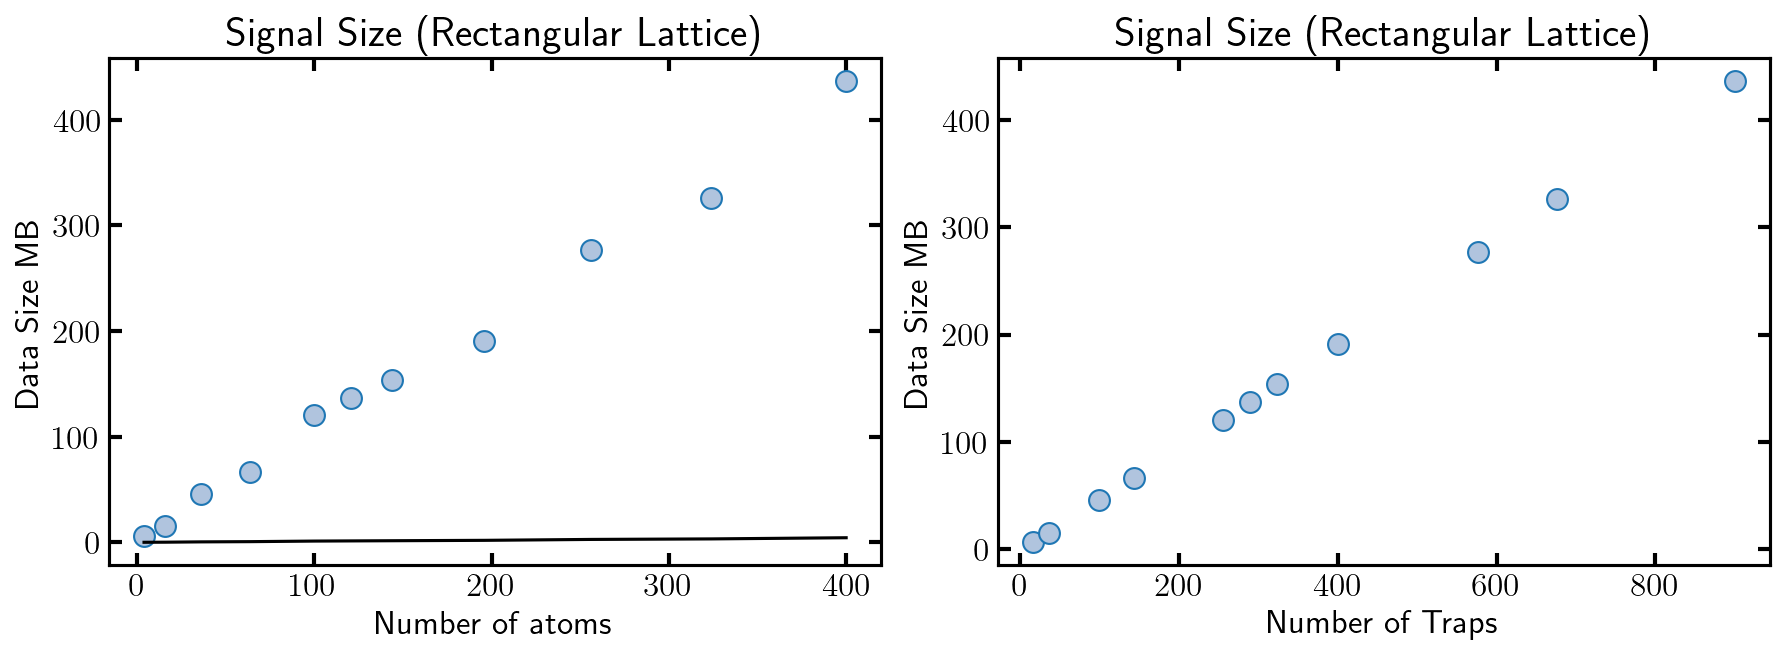

In [4]:
## Plot configs
fig = plt.figure(figsize=(12, 8), dpi = 150)#, constrained_layout=True)
spec = fig.add_gridspec(2, 2, height_ratios=[1, 1])

ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[0, 1])

plot_configs(ax0)
plot_configs(ax1)

# Define data
target_num_lst = [4, 16, 36, 64, 100, 121, 144, 196, 256, 324, 400]

## Analytical
Precal_data = [signal_size_rectangular_lattice(N)/(1024 ** 2) for N in target_num_lst]

# Plot results
filled_marker_style_blue = dict(marker='o', linestyle='None', markersize=10,
                           color='darkgrey',
                           markerfacecolor='lightsteelblue',
                           markerfacecoloralt='lightsteelblue',
                           markeredgecolor='tab:blue')

ax0.plot(target_num_lst, Precal_data, **filled_marker_style_blue)
## Set axis and legends
ax0.set_title(r"Signal Size (Rectangular Lattice)", fontsize = 20)
ax0.set_ylabel(r"Data Size MB", fontsize = 16)
ax0.set_xlabel(r"Number of atoms", fontsize=16)

# Define data
N_trap_lst = [number_total_traps(N) for N in target_num_lst]

# Plot results
filled_marker_style_blue = dict(marker='o', linestyle='None', markersize=10,
                           color='darkgrey',
                           markerfacecolor='lightsteelblue',
                           markerfacecoloralt='lightsteelblue',
                           markeredgecolor='tab:blue')

ax1.plot(N_trap_lst, Precal_data, **filled_marker_style_blue)

## Set axis and legends
ax1.set_title(r"Signal Size (Rectangular Lattice)", fontsize = 20)
ax1.set_ylabel(r"Data Size MB", fontsize = 16)
ax1.set_xlabel(r"Number of Traps", fontsize=16)
plt.tight_layout()
plt.show()


Text(0.5, 0, 'Number of atoms')

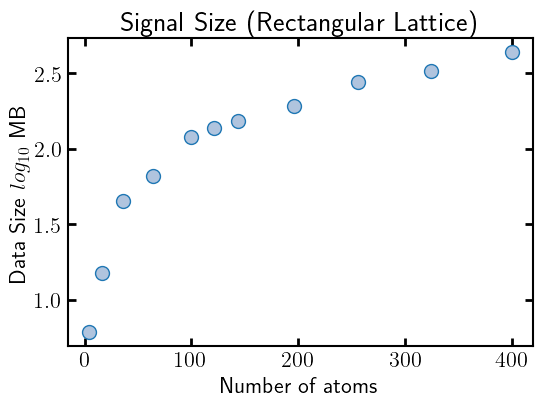

In [12]:
## Plot configs
fig, ax = plt.subplots(figsize=(6,4))
plot_configs(ax)

# Define data
target_num_lst = [4, 16, 36, 64, 100, 121, 144, 196, 256, 324, 400]
target_num_data = np.linspace(0, 400, 1000)
## Analytical
Precal_data = [signal_size_rectangular_lattice(N)/(1024 ** 2) for N in target_num_lst]

# Plot results
filled_marker_style_blue = dict(marker='o', linestyle='None', markersize=10,
                           color='darkgrey',
                           markerfacecolor='lightsteelblue',
                           markerfacecoloralt='lightsteelblue',
                           markeredgecolor='tab:blue')

ax.plot(target_num_lst, np.log10(Precal_data), **filled_marker_style_blue)

# Fit the data usage
coefficients = np.polyfit(target_num_lst, Precal_data, 2)
polynomial = np.poly1d(coefficients)

ax.plot(target_num_data, np.log10(polynomial(target_num_data)/100), '-k')

## Set axis and legends
ax.set_title(r"Signal Size (Rectangular Lattice)", fontsize = 20)
ax.set_ylabel(r"Data Size $log_{10}$ MB", fontsize = 16)
ax.set_xlabel(r"Number of atoms", fontsize=16)

# From Actual Data

In [ ]:
import os
import time
import argparse
from functools import wraps
import h5py
from tqdm import tqdm

# Rearranging algorithm imports
from lib.TrapGeometry.geometry import GeometeryGenerator
from lib.RearrangingAlgo.Path import PathGeneratorSingle, PathGeneratorParallel
from lib.RearrangingAlgo.Evolution import Simulation
import networkx as nx

# Rearranging pulse imports
from lib.Tweezer_control_software.AOD.signal.waveform_gen import (static_wave_gen, 
                                                                precal_tweezer_wave_gen, 
                                                                precal_alignment_wave_gen, 
                                                                cal_parallel_tweezer_wave_gen)

from utils import check_folder, reformat_path

In [ ]:
precal_data_path = "Experiments/AWG/precal_signals/MovingTweezerSignal_rectangular_20231110_115215.hdf5"
precal_data = h5py.File(precal_data_path, 'r')


In [ ]:
# Extract signal mode, can be "static", "grab", "drop", "move"
memory_usage = 0
for signal_mode in ["static", "grab", "drop", "move"]:
    print(f"Loading Mode: {signal_mode} \n")
    
    # Extract signal index with key, in the form of nodes pairs
    signals = list(precal_data[signal_mode]["signal"]) # signals is a 2xt np.array
    print(f"Number of signals: {len(signals)}\n")             
    
    # From the node pairs, extract the signal data
    for signal in tqdm(signals):
        signal_dataset = precal_data[signal_mode]["signal"][signal][()]
        data_channel_0 = signal_dataset[0].astype('float16') 
        data_channel_1 = signal_dataset[1].astype('float16') 
        # print(f"Signal for: {signal}")
        # print(f"Signal for DAC channel 0: {data_channel_0}, Memory usage: {data_channel_0.nbytes/(1024)**2} MB")
        # print(f"Signal for DAC channel 1: {data_channel_1}, Memory usage: {data_channel_1.nbytes/(1024)**2} MB\n")
        memory_usage += (data_channel_0.nbytes + data_channel_1.nbytes)
print(f'Total memory usage: {memory_usage/(1024**2)} MB')


Loading Mode: static 

Number of signals: 1



100%|██████████| 1/1 [00:00<00:00, 71.28it/s]


Loading Mode: grab 

Number of signals: 900



100%|██████████| 900/900 [00:00<00:00, 3321.23it/s]


Loading Mode: drop 

Number of signals: 900



100%|██████████| 900/900 [00:00<00:00, 3842.64it/s]


Loading Mode: move 

Number of signals: 3480



100%|██████████| 3480/3480 [00:02<00:00, 1521.00it/s]

Total memory usage: 438.690185546875 MB
